
# 1D Inversion of for a Single Sounding of Permafrost layers

**Based on:** module from *simpeg.electromangetics.frequency_domain_1d* to invert
frequency domain data and recover a 1D electrical conductivity model.

**Survey:** Forward simulation to mimic the permafrost structure of the AEM survey conducted in August, 2024, by Xcalibur Multiphysic. In the Inuvik-Tuktoyaktuk-Highway (ITH) project. Magnetic dipole at 35 m above the Earth's surface. The receiver is offset\
10 m horizontally from the source.

## Import modules




In [19]:
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import simpeg.electromagnetics.frequency_domain as fdem
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})

# sphinx_gallery_thumbnail_number = 2

## Open data from Forward Simluation



In [22]:
# Path to saved data, output folder. same directory
data_filename = os.path.join("outputs", "em1dfm_data.txt")

## Load Data and Plot

Here we load and plot the 1D sounding data. In this case, we have the
secondary field response in ppm for a set of frequencies.




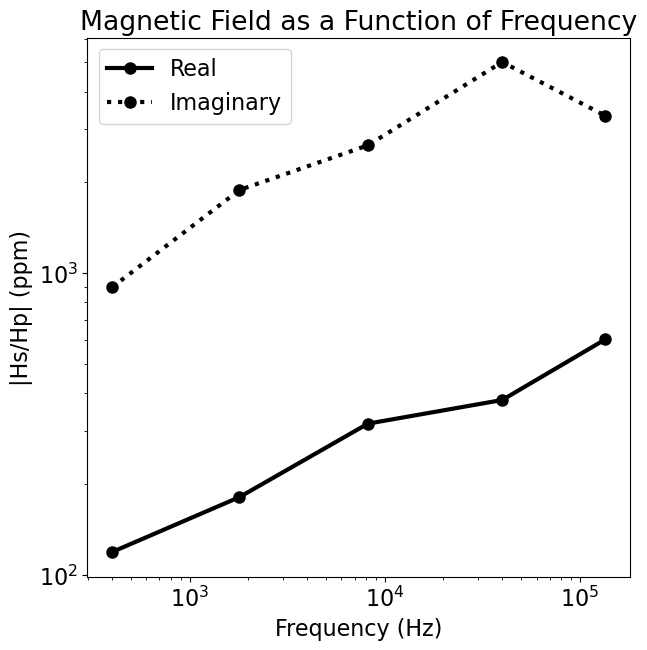

In [25]:
# Load field data
# dobs = np.loadtxt(str(data_filename))
dobs = np.loadtxt(str(data_filename), skiprows=1)

# Define receiver locations and observed data
frequencies = dobs[:, 0]
dobs = mkvc(dobs[:, 1:].T)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.loglog(frequencies, np.abs(dobs[0::2]), "k-o", lw=3)
ax.loglog(frequencies, np.abs(dobs[1::2]), "k:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("|Hs/Hp| (ppm)")
ax.set_title("Magnetic Field as a Function of Frequency")
ax.legend(["Real", "Imaginary"])

## Defining the Survey

Based on RESOLVE 6 system flew by by Xcalibur Multiphysic in August 2024. Nominal frequencies 135 kHz, 40 kHz, 8.2 kHz, 1.8 kHz and 400 Hz. The flight-line spacing was 100 m, and the average terrain clearance was 35 m for the RESOLVE bird.  





In [27]:
source_location = np.array([0.0, 0.0, 35.0])
moment = 1.0

receiver_location = np.array([10.0, 0.0, 35.0])
receiver_orientation = "z"
data_type = "ppm"

# Receiver list
receiver_list = []
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="real",
    )
)
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="imag",
    )
)

# Define source list
source_list = []
for freq in frequencies:
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation="z",
            moment=moment,
        )
    )

# Survey
survey = fdem.survey.Survey(source_list)

## Assign Uncertainties and Define the Data Object

Uncertainties based on noise level added on forward simulation



In [31]:
# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

# Define the data object
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

## Defining a 1D Layered Earth (1D Tensor Mesh)

Here, we define the layer thicknesses for our 1D simulation. To do this, we use
the TensorMesh class.




In [34]:
# Layer thicknesses
inv_thicknesses = np.logspace(0, 1.5, 25)

# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], "0")

## Define a Starting and/or Reference Model and the Mapping

Create the model active cells and starting background conductivity


In [37]:
#set background conducivity 
starting_conductivity = 0.05

# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(starting_conductivity * np.ones(mesh.nC))

# Define mapping from model to active cells.
model_mapping = maps.ExpMap()

## Define the Physics using a Simulation Object




In [40]:
simulation = fdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=model_mapping
)

## Define Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem





In [43]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg_map = maps.IdentityMap(nP=mesh.nC)
reg = regularization.Sparse(mesh, mapping=reg_map, alpha_s=0.025, alpha_x=1.0)

# reference model
reg.reference_model = starting_model

# Define sparse and blocky norms p, q
reg.norms = [0, 0]

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(maxIter=50, maxIterLS=20, maxIterCG=30, tolCG=1e-3)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.




In [46]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Update the preconditionner
update_Jacobi = directives.UpdatePreconditioner()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Directive for the IRLS
update_IRLS = directives.Update_IRLS(
    max_irls_iterations=100, minGNiter=1, coolEpsFact=1.5, update_beta=True
)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights()

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    save_iteration,
    update_IRLS,
    update_jacobi,
]

/var/folders/gb/v44v1_q914718nzwmm90d6pr0000gn/T/ipykernel_60065/4193565355.py:12: DeprecationWarning: Update_IRLS has been deprecated, please use InversionDirective. It will be removed in version 0.24.0 of SimPEG.
  update_IRLS = directives.Update_IRLS(


## Running the Inversion

**There is a bug in this inversion :(**

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [49]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.1.dev1+g60e0c3a5

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.09e+03  4.54e+04  6.86e-32  4.54e+04    1.20e+04      0              


/opt/anaconda3/lib/python3.12/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: SolverLU. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
/opt/anaconda3/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


   1  2.04e+03  1.49e+04  1.10e+00  1.72e+04    3.80e+03      0              
   2  1.02e+03  6.84e+03  1.57e+00  8.44e+03    1.74e+03      0              
   3  5.11e+02  3.70e+03  2.01e+00  4.73e+03    8.55e+02      0              
   4  2.55e+02  2.53e+03  2.30e+00  3.12e+03    4.92e+02      0              
   5  1.28e+02  1.99e+03  2.51e+00  2.31e+03    2.60e+02      0   Skip BFGS  
   6  6.38e+01  1.84e+03  2.48e+00  2.00e+03    2.34e+02      1   Skip BFGS  
   7  3.19e+01  1.74e+03  2.92e+00  1.83e+03    1.95e+02      0   Skip BFGS  
   8  1.60e+01  1.72e+03  3.46e+00  1.77e+03    2.22e+02      1              
   9  7.98e+00  1.68e+03  3.07e+00  1.70e+03    1.78e+02      1              
  10  3.99e+00  1.67e+03  3.30e+00  1.68e+03    1.92e+02      4              
  11  1.99e+00  1.66e+03  3.79e+00  1.67e+03    2.12e+02      4   Skip BFGS  
  12  9.97e-01  1.66e+03  4.62e+00  1.66e+03    2.46e+02      4   Skip BFGS  
  13  4.99e-01  1.66e+03  5.25e+00  1.66e+03    2.64e+02      5 

/opt/anaconda3/lib/python3.12/site-packages/simpeg/maps/_property_maps.py:48: RuntimeWarning: overflow encountered in exp
  return np.exp(mkvc(m))


  26  6.09e-05  1.65e+03  9.79e+00  1.65e+03    3.49e+02     13   Skip BFGS  
  27  3.04e-05  1.65e+03  1.01e+01  1.65e+03    3.51e+02     13   Skip BFGS  
  28  1.52e-05  1.65e+03  1.04e+01  1.65e+03    3.52e+02     13   Skip BFGS  
  29  7.61e-06  1.65e+03  1.07e+01  1.65e+03    3.52e+02     14   Skip BFGS  
  30  3.80e-06  1.65e+03  1.09e+01  1.65e+03    3.53e+02     14   Skip BFGS  
  31  1.90e-06  1.65e+03  1.12e+01  1.65e+03    3.54e+02     14   Skip BFGS  
  32  9.51e-07  1.65e+03  1.12e+01  1.65e+03    3.54e+02     16   Skip BFGS  
  33  4.76e-07  1.65e+03  1.12e+01  1.65e+03    3.54e+02     18   Skip BFGS  
------------------------------------------------------------------
0 :    ft     = 1.6505e+03 <= alp*descent     = 1.6505e+03
1 : maxIterLS =      20    <= iterLS          =     20
------------------------- End Linesearch -------------------------
The linesearch got broken. Boo.


## Plotting Results




In [72]:
# Load the true model and layer thicknesses
#true_model = np.array([0.1, 1.0, 0.1])
#true_layers = np.r_[20.0, 40.0, 160.0]

# Extract Least-Squares model
l2_model = inv_prob.l2model
#l2_model = update_IRLS.

# Plot true model and recovered model
fig = plt.figure(figsize=(8, 9))
#x_min = np.min(
#    np.r_[model_mapping * recovered_model, model_mapping * l2_model, true_model]
#)
#x_max = np.max(
#    np.r_[model_mapping * recovered_model, model_mapping * l2_model, true_model]
#)

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
#plot_1d_layer_model(true_layers, true_model, ax=ax1, show_layers=False, color="k")
plot_1d_layer_model(
    mesh.h[0], model_mapping * l2_model, ax=ax1, show_layers=False, color="b"
)
plot_1d_layer_model(
    mesh.h[0], model_mapping * recovered_model, ax=ax1, show_layers=False, color="r"
)
ax1.set_xlim(0.01, 10)
ax1.set_title("True and Recovered Models")
ax1.legend(["True Model", "L2-Model", "Sparse Model"])
plt.gca().invert_yaxis()

# Plot predicted and observed data
dpred_l2 = simulation.dpred(l2_model)
dpred_final = simulation.dpred(recovered_model)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(frequencies, np.abs(dobs[0::2]), "k-o")
ax1.loglog(frequencies, np.abs(dobs[1::2]), "k:o")
ax1.loglog(frequencies, np.abs(dpred_l2[0::2]), "b-o")
ax1.loglog(frequencies, np.abs(dpred_l2[1::2]), "b:o")
ax1.loglog(frequencies, np.abs(dpred_final[0::2]), "r-o")
ax1.loglog(frequencies, np.abs(dpred_final[1::2]), "r:o")
ax1.set_xlabel("Frequencies (Hz)")
ax1.set_ylabel("|Hs/Hp| (ppm)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(
    [
        "Observed (real)",
        "Observed (imag)",
        "L2-Model (real)",
        "L2-Model (imag)",
        "Sparse (real)",
        "Sparse (imag)",
    ],
    loc="upper left",
)
plt.show()

AttributeError: 'BaseInvProblem' object has no attribute 'l2model'